<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro/References" data-toc-modified-id="Intro/References-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro/References</a></span></li><li><span><a href="#Scaling-not-clipping?" data-toc-modified-id="Scaling-not-clipping?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scaling not clipping?</a></span></li><li><span><a href="#Pytorch" data-toc-modified-id="Pytorch-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pytorch</a></span></li><li><span><a href="#Pytorch-monitor" data-toc-modified-id="Pytorch-monitor-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pytorch monitor</a></span><ul class="toc-item"><li><span><a href="#Vectorizing-is-terrible/awesome." data-toc-modified-id="Vectorizing-is-terrible/awesome.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Vectorizing is terrible/awesome.</a></span></li></ul></li></ul></div>

# Intro/References

A Distributional Perspective on Reinforcement Learning
https://deepmind.com/blog/going-beyond-average-reinforcement-learning/
https://arxiv.org/abs/1707.06887

Distributional Reinforcement Learning with Quantile Regression
https://arxiv.org/abs/1710.10044

Distributional RL
https://mtomassoli.github.io/2017/12/08/distributional_rl/

An Analysis of Categorical Distributional Reinforcement Learning
https://arxiv.org/abs/1802.08163



    
# Scaling not clipping?

# Pytorch
# Pytorch monitor

In [3]:
from collections import (deque, defaultdict)
import math
import random
import sys

import attr
import gym
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
from pytorch_monitor import init_experiment, monitor_module
from smooth import smooth  # timeseries smoothing function
import torch
from torch import nn
import torch.nn.functional as F


cartpole = gym.make('CartPole-v1')
lunarlander = gym.make('LunarLander-v2')
plt.style.use('seaborn-white')

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'  

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [59]:
@attr.s
class Memory(deque):
    """ Experience Replay Memory class. """
    size = attr.ib()
    minibatch_size = attr.ib()

    def append(self, thing):
        if len(self) > self.size - 1:
            self.popleft()
        return super().append(thing)

    def sample(self):
        batch_size = min(len(self), self.minibatch_size)
        data = random.sample(self, batch_size)
        states = torch.stack([record[0] for record in data])
        actions = torch.tensor([record[1] for record in data], dtype=torch.long)
        rewards = torch.tensor([record[2] for record in data], dtype=torch.float)
        states_ = torch.stack([record[3] for record in data])
        dones = torch.tensor([record[4] for record in data], dtype=torch.long)
        return (states, actions, rewards, states_, dones)


class ValueDistributionDeep(torch.nn.Module):
    def __init__(self, state_shape, action_shape, vmin, vmax, num_atoms=51, num_hidden1_units=64, num_hidden2_units=64):
        super().__init__()
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.vmin = vmin
        self.vmax = vmax
        self.num_atoms = num_atoms
        self.atoms = torch.linspace(self.vmin, self.vmax, self.num_atoms)
        self.linear1 = nn.Linear(self.state_shape, num_hidden1_units)
        self.linear2 = nn.Linear(num_hidden1_units, num_hidden2_units)
        self.linear3 = nn.Linear(num_hidden2_units, num_hidden2_units)
        self.linear4 = nn.Linear(num_hidden2_units, self.action_shape * self.num_atoms)
        
    def forward(self, x):
        """ Return (actions x atoms). """
        x1 = F.selu(self.linear1(x))
        x2 = F.selu(self.linear2(x1))
        x3 = F.selu(self.linear3(x2))
        x4 = self.linear4(x3).reshape(-1, self.action_shape, self.num_atoms)
        out = F.softmax(x4, dim=2)  # (actions x atoms)
        if x.dim() == 1:
            batch_size = 1
        else:
            batch_size = x.size(0)
        assert out.size() == torch.Size((batch_size, self.action_shape, self.num_atoms))
        if hasattr(self, 'monitor'):
            self.monitor('x1', x1, track_data=True, track_grad=True)
            self.monitor('x2', x2, track_data=True, track_grad=True)
            self.monitor('x3', x3, track_data=True, track_grad=True)
            self.monitor('x4', x4, track_data=True, track_grad=True)
            self.monitor('out', out, track_data=True, track_grad=True)
        return out
    
    def predict_action_values(self, states):
        """ Return (batch-size x actions). """
        distribution = self.forward(states)
        weighted_distribution = distribution * self.atoms
        out = weighted_distribution.sum(dim=2).squeeze()  # (batch-size x actions)
        dims = states.dim()
        assert out.size() == torch.Size((self.action_shape,))
        return out
        
    def get_action(self, state):        
        values = self.predict_action_values(state)
        action = values.argmax()
        return action
    
    
class ValueDistribution(torch.nn.Module):
    def __init__(self, state_shape, action_shape, vmin, vmax, num_atoms=51, num_hidden1_units=64, num_hidden2_units=64):
        super().__init__()
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.vmin = vmin
        self.vmax = vmax
        self.num_atoms = num_atoms
        self.atoms = torch.linspace(self.vmin, self.vmax, self.num_atoms)
        self.batch_norm = nn.BatchNorm1d(state_shape)
        self.linear1 = nn.Linear(self.state_shape, num_hidden1_units)
        self.linear2 = nn.Linear(num_hidden1_units, self.action_shape * self.num_atoms)
        
    def forward(self, x):
        """ Return (actions x atoms). """
        if x.dim() > 1:
            x0 = self.batch_norm(x)
        else:
            x0 = x
        x1 = F.relu(self.linear1(x0))
        x2 = self.linear2(x1).reshape(-1, self.action_shape, self.num_atoms)
        out = F.softmax(x2, dim=2)  # (actions x atoms)
        if x.dim() == 1:
            batch_size = 1
        else:
            batch_size = x.size(0)
        assert out.size() == torch.Size((batch_size, self.action_shape, self.num_atoms))
        if hasattr(self, 'monitor'):
            self.monitor('x0', x0, track_data=True, track_grad=True)
            self.monitor('x1', x1, track_data=True, track_grad=True)
            self.monitor('x2', x2, track_data=True, track_grad=True)
            self.monitor('out', out, track_data=True, track_grad=True)
        return out
    
    def predict_action_values(self, states):
        """ Return (batch-size x actions). """
        distribution = self.forward(states)
        weighted_distribution = distribution * self.atoms
        out = weighted_distribution.sum(dim=2).squeeze()  # (batch-size x actions)
        dims = states.dim()
        assert out.size() == torch.Size((self.action_shape,))
        return out
        
    def get_action(self, state):        
        values = self.predict_action_values(state)
        action = values.argmax()
        return action

## Vectorizing is terrible/awesome.

This is the algo we'll be implementing. 

![The C51 algorithm](assets/C51-algo.png)

Vectorizing this code is *very* important. Even on my lowely macbook, the fully vectorized version of this algorithm that accepts a minibatch runs about *30 times* faster than a naive implementation that's called inside a loop. This cashes out to 1000 training episodes of LunarLander in about 10 minutes, verses five hours. 

My process for vectoring this code was.. to sort of squint at it. 
Seriously. I wasn't even sure if I should first generalize it to accept minibatch tensors and then remove the loop, or vice versa. 

Squinting at it, thought, (and stepping through it line by line in Jupyter a few times), it became clear that the would actually tricky to vectorize: 

![The bastard lines]](assets/C51-algo-large.png)

I decided to take the easy wins first, and first converted the `categorical_loss` function to accept minibatches first. This is straighforward, mostly just reshaping and expanding tensors. Pytorch's `squeeze` and `unsqueeze` methods have fun names and are great for this. 

Those two lines, though, were bloody horrible. 

They ended up cashing out into the following dense six lines of python:

```python
offset_bound = target_net.num_atoms * batch_size - target_net.num_atoms
idx_offset = torch.range(0, offset_bound, target_net.num_atoms).unsqueeze(1).expand_as(m)
lo_idx = (lo + idx_offset).view(-1).type(torch.long)
hi_idx = (hi + idx_offset).view(-1).type(torch.long)
lo_component = m.view(-1).index_add(0, lo_idx, (probabilities * (hi - b_j)).view(-1) )
hi_component = m.view(-1).index_add(0, hi_idx, (probabilities * (b_j - lo)).view(-1) )
m += lo_component.resize_as(m) + hi_component.resize_as(m)       
```

The main insight is that the `lo` and `hi` tensors contain routing information. They tend look like this:

```
lo:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10]])
hi:
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 10],
        [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10]])
```

This is for a three-transition test minibatch. The values are the target indicies for where probability needs to accumulate inside `m` our new probability-mass tensor.

Eventually after squinting a lot at the PyTorch docs, I figured out that PyTorch's [`index_add`](https://pytorch.org/docs/stable/tensors.html?highlight=index_add#torch.Tensor.index_add_) method would do the trick. 

Usings `index_add` requires that all the tensors be unrolled, which is why we need index-offsets. Put it together, and you're done.



In [5]:
def categorical_vectorized_loss(online_net, target_net, transitions, discount): 
    states, actions, rewards, states_, dones = transitions
    not_dones = (1 - dones).type(torch.FloatTensor)
    atoms = target_net.atoms
    probabilities = target_net.forward(states_)
    Q_x_ = (probabilities * atoms).sum(2)
    batch_size = states.shape[0]
    assert Q_x_.shape == torch.Size((batch_size, target_net.action_shape)), f'Got: {Q_x_.shape}, expected: {(batch_size, target_net.action_shape)}'
    a_star = Q_x_.argmax(dim=1) 
    assert a_star.shape == torch.Size((batch_size,)), f'Got {a_star.shape}, expected: ((batch_size,))'
    
    # compute the projected probability:
    delta_z = (target_net.vmax - target_net.vmin)/(target_net.num_atoms - 1)    
    # select only the probabilities distributions for the a_star actions:
    probabilities = probabilities[range(batch_size), a_star]
    T_zj = rewards.unsqueeze(1) + discount * atoms * not_dones.unsqueeze(1)
    b_j = (T_zj.clamp(target_net.vmin, target_net.vmax) - target_net.vmin) / delta_z  # correct    
    lo = b_j.floor()        
    hi = b_j.ceil()
    m = torch.zeros(batch_size, target_net.num_atoms, dtype=torch.float)
    lo_component = torch.zeros_like(m.view(-1))
    hi_component = torch.zeros_like(m.view(-1))
    # offset will be used for indexing when we flatten the tensors into vectors:
    offset_bound = target_net.num_atoms * batch_size - target_net.num_atoms
    idx_offset = torch.range(0, offset_bound, target_net.num_atoms).unsqueeze(1).expand_as(m)
    lo_idx = (lo + idx_offset).view(-1).type(torch.long)
    hi_idx = (hi + idx_offset).view(-1).type(torch.long)
    lo_component = m.view(-1).index_add(0, lo_idx, (probabilities * (hi - b_j)).view(-1) )
    hi_component = m.view(-1).index_add(0, hi_idx, (probabilities * (b_j - lo)).view(-1) )
    m += lo_component.reshape(batch_size, target_net.num_atoms) + hi_component.reshape(batch_size, target_net.num_atoms)
    # cross enthropy is Sigma <true> log <unnatural>, so for us is: target log(online)
    online_distribution = online_net.forward(states)[range(batch_size), actions]
    return -( m * online_distribution.log() ).sum(1).mean()

In [24]:
@attr.s
class CategoricalAgent:
    env = attr.ib()
    discount = attr.ib(default=0.99)
    epsilon_max = attr.ib(default=1.0)
    epsilon_min = attr.ib(default=0.01)
    annealing_const = attr.ib(default=.001)  # aka Lambda
    minibatch_size = attr.ib(default=32)
    memory_size = attr.ib(default=int(1e6))
    num_episodes = attr.ib(default=1000)  # num of episodes in a training epoch
    render_every = attr.ib(default=20)  # set to zero to turn off rendering
    update_target_every = attr.ib(default=200)
    vmin = attr.ib(default=-10)
    vmax = attr.ib(default=10)
    num_atoms = attr.ib(default=51)
    learning_rate = attr.ib(default=0.000001)
    monitor_total = attr.ib(default=10)
    logger = attr.ib(default=None)
    reward_scaling = attr.ib(default=1.0)
    xavier = attr.ib(default=True)
    weight_decay = attr.ib(default=0)
    use_lr_scheduler = attr.ib(default=True)
    
    def __attrs_post_init__(self):
        self.steps = 0
        state_shape = self.env.observation_space.shape[0]
        self.memory = Memory(self.memory_size, self.minibatch_size)
        self.action_shape = self.env.action_space.n
        self.online_net = ValueDistribution(state_shape=state_shape, action_shape=self.action_shape, vmin=self.vmin, vmax=self.vmax, num_atoms=self.num_atoms)
        self.target_net = ValueDistribution(state_shape=state_shape, action_shape=self.action_shape, vmin=self.vmin, vmax=self.vmax, num_atoms=self.num_atoms)
        if self.xavier:
            gain = nn.init.calculate_gain('relu')
            for param in self.online_net.parameters():
                if param.dim() < 2:
                    continue
                nn.init.xavier_uniform_(param, gain=gain)        
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.optimizer = torch.optim.Adam(self.online_net.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.steps = 0
        self.target_net_q_values = []
        self.episode_rewards = []
        self.training_loss = []
        self.monitor_every = self.num_episodes//self.monitor_total
        self.setup_lr_scheduler()
    
    def setup_lr_scheduler(self):
        if not self.use_lr_scheduler:
            return        
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            'max', 
            factor=.5, 
            patience=200,
            cooldown=100,
            verbose=True
        )
        
    def render(self, episode):
        if self.render_every and episode % self.render_every == 0:
            self.env.render()

    def training_progress_report(self, episode):
        last_ep = self.episode_rewards[-1]
        ten_ep_mean = sum(self.episode_rewards[-10:])/len(self.episode_rewards[-10:])
        hundred_ep_mean = sum(self.episode_rewards[-100:])/len(self.episode_rewards[-100:])
        lin1_grad = self.online_net.linear1.weight.grad.norm()
        lin2_grad = self.online_net.linear2.weight.grad.norm()
        return f'Ep: {episode} // steps: {self.steps} // last ep reward: {last_ep:.2f} // {min(10, len(self.episode_rewards[-10:]))}-ep mean: {ten_ep_mean:.2f} // {min(100, len(self.episode_rewards[-100:]))}-ep mean: {hundred_ep_mean:.2f}, layer1 grad: {lin1_grad:.2f}, layer2 grad: {lin2_grad:.2f}'

    def replay(self):
        batch = self.memory.sample()
        loss = categorical_vectorized_loss(self.online_net, self.target_net, batch, self.discount)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()/self.minibatch_size

    def monitor(self):
        if not hasattr(self.target_net, 'monitoring'):
            return
        if self.monitor_every and self.steps % self.monitor_every == 0:
            self.target_net.monitoring(True)
        else:
            self.target_net.monitoring(False)

    def train(self):
        for episode in range(self.num_episodes):
            episode_done = False
            episode_reward = 0
            episode_loss = 0
            state = torch.tensor(self.env.reset(), dtype=torch.float)
            self.target_net_q_values.append(self.target_net.predict_action_values(state).max().item())
            if self.steps == 0 and self.logger:
                self.logger.add_graph(self.target_net, state)
            self.logger.add_scalar('Target net Q values', self.target_net_q_values[-1], episode)                
            while not episode_done:
                self.monitor()
                epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * math.exp(-self.annealing_const * self.steps)
                self.steps += 1                
                if random.random() < epsilon:
                    action = random.randint(0, self.action_shape-1)
                else:
                    action = self.online_net.get_action(state).item()
                self.render(episode)
                self.monitor()
                state_, reward, episode_done, _ = self.env.step(action)
                reward *= self.reward_scaling
                state_ = torch.tensor(state_, dtype=torch.float)
                episode_reward += reward
                self.memory.append((state, action, reward, state_, episode_done))
                state = state_
                if self.steps < 2:
                    continue
                episode_loss += self.replay()
                
                if self.steps % self.update_target_every == 0:
                    self.target_net.load_state_dict(self.online_net.state_dict())
                if episode_done:
                    self.episode_rewards.append(episode_reward)
                    self.training_loss.append(episode_loss)
                    print(self.training_progress_report(episode), end='\r', flush=True)
                    self.logger.add_scalar('train loss', episode_loss, episode)
                    self.logger.add_scalar('episode reward', episode_reward, episode)                    

                    if self.use_lr_scheduler and episode > 11:                    
                        # smoothed_loss = smooth(np.array(self.training_loss[-100:])).mean()
                        smoothed_reward = smooth(np.array(self.episode_rewards[-100:])).mean()
                        self.scheduler.step(smoothed_reward)
                    
        self.env.close()

    def test(self):
        pass

In [20]:
# Enable monitoring
def run_experiment(agent, logger, title):
    #try:
    monitor_module(agent.target_net, logger, 
                   track_data=True,
                   track_grad=True,
                   track_update=True,
                   track_update_ratio=True)

    agent.train()
    #except:
    #    print(sys.exc_info()[0])

In [23]:
experiments = {}

In [ ]:
def param_search():
    for _ in range(10):
        lr = 10 ** np.random.uniform(-3, -1)
        l2 = 10 ** np.random.uniform(-4, 0)
        xavier = True
        title = f'LR: {lr:.2f} / L2 reg: {l2} / Xavier: {xavier}'
        config = {
            'title':title,
            'log_dir':'tuning-categorical',
            'random_seed':0
        }

        logger, config = init_experiment(config)
        print(config)
        agent = CategoricalAgent(
            lunarlander, 
            learning_rate=lr, 
            num_episodes=1000,
            update_target_every=200,  
            reward_scaling=1,
            logger=logger,
            weight_decay=l2,
            xavier=xavier
        )
        experiments[(lr, l2, xavier)] = agent

        run_experiment(agent, logger, title=title)
        
param_search()

{'title': 'LR: 0.01 / L2 reg: 0.07257005721594274 / Xavier: True', 'log_dir': 'tuning-categorical', 'random_seed': 0, 'run_name': 'Jul-20-18@18:42:13-DaydreamNation.local', 'run_dir': 'tuning-categorical/Jul-20-18@18:42:13-DaydreamNation.local', 'tag': 'Experiment Config: LR: 0.01 / L2 reg: 0.07257005721594274 / Xavier: True :: Jul-20-18@18:42:13\n'}


/Users/liavkoren/Envs/ai-gym/lib/python3.6/site-packages/torch/onnx/utils.py:365: UserWarning: ONNX export failed on ATen operator reshape because torch.onnx.symbolic.reshape does not exist
  .format(op_name, op_name))


Epoch   206: reducing learning rate of group 0 to 6.2603e-03.ean: -235.72 // 100-ep mean: -294.46, layer1 grad: 0.00, layer2 grad: 0.00
Epoch   507: reducing learning rate of group 0 to 3.1302e-03.ean: -317.74 // 100-ep mean: -300.64, layer1 grad: 0.00, layer2 grad: 0.00
Epoch   808: reducing learning rate of group 0 to 1.5651e-03.ean: -344.98 // 100-ep mean: -342.29, layer1 grad: 0.00, layer2 grad: 0.00


In [57]:
%debug

> /Users/liavkoren/Envs/ai-gym/lib/python3.6/site-packages/torch/nn/functional.py(1194)batch_norm()
   1192     return torch.batch_norm(
   1193         input, weight, bias, running_mean, running_var,
-> 1194         training, momentum, eps, torch.backends.cudnn.enabled
   1195     )
   1196 

ipdb> u
> /Users/liavkoren/Envs/ai-gym/lib/python3.6/site-packages/torch/nn/modules/batchnorm.py(49)forward()
     47         return F.batch_norm(
     48             input, self.running_mean, self.running_var, self.weight, self.bias,
---> 49             self.training or not self.track_running_stats, self.momentum, self.eps)
     50 
     51     def extra_repr(self):

ipdb> u
> /Users/liavkoren/Envs/ai-gym/lib/python3.6/site-packages/torch/nn/modules/module.py(491)__call__()
    489             result = self._slow_forward(*input, **kwargs)
    490         else:
--> 491             result = self.forward(*input, **kwargs)
    492         for hook in self._forward_hooks.values():
    493            

In [32]:
experiments

{(0.012520653814999462,
  0.8581071389208439,
  True): CategoricalAgent(env=<TimeLimit<LunarLander<LunarLander-v2>>>, discount=0.99, epsilon_max=1.0, epsilon_min=0.01, annealing_const=0.001, minibatch_size=32, memory_size=1000000, num_episodes=1000, render_every=20, update_target_every=200, vmin=-10, vmax=10, num_atoms=51, learning_rate=0.012520653814999462, monitor_total=10, logger=<tensorboardX.writer.SummaryWriter object at 0x129556898>, reward_scaling=0.3, xavier=True, weight_decay=0.8581071389208439, use_lr_scheduler=True)}

In [46]:
rewards = np.array([trans[2] for trans in agent.memory])
# plt.hist(rewards)


In [47]:
np.percentile(rewards, [25, 50, 75]), rewards.min(), rewards.max()

(array([-0.86426283, -0.52690692, -0.09888515]), -30.0, 36.23615053486309)

(array([2.8000e+01, 3.9000e+01, 5.4000e+01, 6.5000e+01, 6.9000e+01,
        9.4000e+01, 9.3000e+01, 1.2400e+02, 1.5300e+02, 2.0300e+02,
        2.2200e+02, 2.2700e+02, 3.2400e+02, 3.8700e+02, 5.4800e+02,
        8.0300e+02, 1.1990e+03, 2.1280e+03, 3.5660e+03, 5.9610e+03,
        1.0508e+04, 1.4669e+04, 1.4377e+04, 1.0905e+04, 7.6650e+03,
        5.5570e+03, 4.3780e+03, 3.6480e+03, 2.4690e+03, 1.4960e+03,
        1.0870e+03, 6.1900e+02, 2.5900e+02, 1.6300e+02, 1.5500e+02,
        1.1000e+02, 1.0700e+02, 6.4000e+01, 5.6000e+01, 4.6000e+01,
        4.0000e+01, 2.4000e+01, 3.2000e+01, 2.6000e+01, 2.8000e+01,
        2.1000e+01, 1.3000e+01, 1.4000e+01, 1.5000e+01, 1.2000e+01]),
 array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
        -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
        -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
         1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
         3.8,  4. ,  4

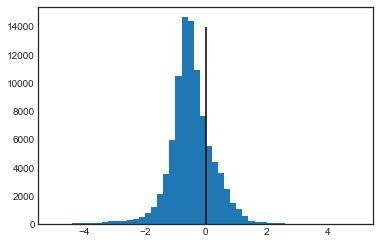

In [51]:
plt.hist(rewards, range=[-5, 5], bins=50);
plt.vlines(0, 0, 14000)

In [55]:
states, actions, rewards, states_, dones = agent.memory.sample()
rewards > 0

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  1,  1,  1,  0,
         0,  1,  0,  1], dtype=torch.uint8)

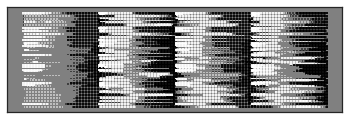

In [69]:

hinton(agent.target_net.linear2.weight.detach())

In [ ]:
plt.show()

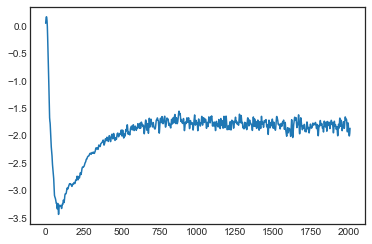

In [49]:
plt.plot(smooth(np.array(agent.target_net_q_values)))

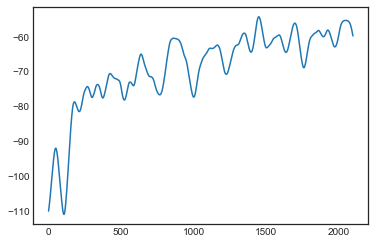

In [50]:
# plt.plot(smooth(np.array(agent.target_net_q_values)))
plt.plot(smooth(np.array(agent.episode_rewards), window_len=100) )


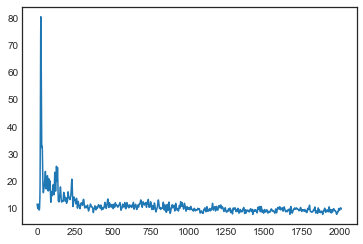

In [51]:
plt.plot(smooth(np.array(agent.training_loss)))

In [67]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [ ]:
# Debugging

Getting this working took a *lot* of debugging time. I went fairly far down a blind alley 

    - not the exploding gradients: small step size was a blind alley
    - not the layer init
    - Debugging w. three-armed bandit
    - comparing against other implementations?
